c:\Users\yudha\OneDrive\Dokumen\MY JOURNEY\ML-SLB\SCALE-UP+ELIMINATION+ROUND+CASE+AND+PROBLEM\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:25:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Rincian F1 Score untuk Setiap Kelas:

              precision    recall  f1-score   support

     30000.0       0.92      0.92      0.92      8771
     65000.0       0.94      0.98      0.96     28993
     65030.0       0.85      0.69      0.76      4057
     70000.0       0.93      0.85      0.89      3353
     70032.0       0.97      0.98      0.98      1069
     74000.0       0.84      0.50      0.63       222
     80000.0       0.90      0.91      0.91      1649
     86000.0       0.95      0.90      0.92       184
     88000.0       0.98      0.99      0.99       784
     90000.0       0.89      0.81      0.85       205
     93000.0       1.00      0.96      0.98        28
     99000.0       0.91      0.96      0.94       765

    accuracy                           0.93     50080
   macro avg       0.92      0.87      0.89     50080
weighted avg       0.93      0.93      0.93     50080



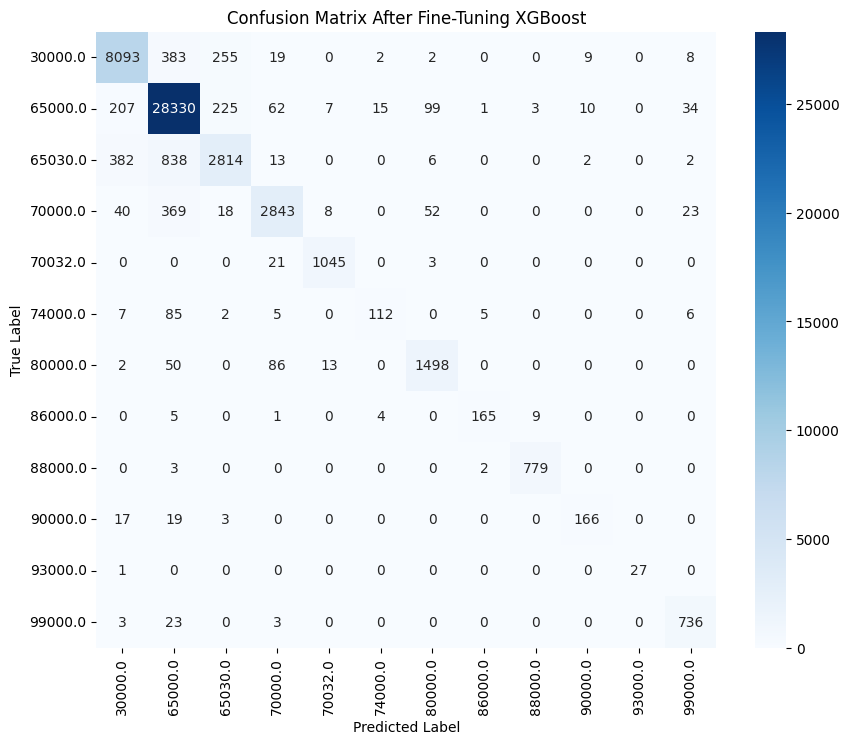


✅ Submission file saved as 'submission_xgb_tuned.csv'.


In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train_data = pd.concat([pd.read_csv(os.path.join("Train dataset", file)) for file in os.listdir("Train dataset") if file.endswith('.csv')], ignore_index=True)
test_data = pd.read_csv("Test_dataset.csv")
labels_df = pd.read_csv("Labels_code.csv")
labels_df.columns = ["label_code", "label_name"]

# Hapus fitur dengan missing values lebih dari 80%
train_data.drop(columns=["DTS", "ROPA", "RMIC", "RXO"], inplace=True, errors='ignore')
test_data.drop(columns=["DTS", "ROPA", "RMIC", "RXO"], inplace=True, errors='ignore')

# Hapus kolom filename karena tidak berguna
train_data.drop(columns=["filename"], inplace=True, errors='ignore')
test_data.drop(columns=["filename"], inplace=True, errors='ignore')

# Konversi DTC ke numerik (jika ada nilai non-numerik, ubah ke NaN dulu)
train_data["DTC"] = pd.to_numeric(train_data["DTC"], errors='coerce')
test_data["DTC"] = pd.to_numeric(test_data["DTC"], errors='coerce')

# Hapus baris dengan target label NaN
train_data.dropna(subset=["Lithology_code"], inplace=True)

# Imputasi missing values pada fitur numerik dengan median
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("Lithology_code")  # Jangan imputasi target
train_data[numeric_cols] = train_data[numeric_cols].fillna(train_data[numeric_cols].median())
test_data[numeric_cols] = test_data[numeric_cols].fillna(test_data[numeric_cols].median())

# Encode target variable
label_encoder = LabelEncoder()
train_data["Lithology_code"] = label_encoder.fit_transform(train_data["Lithology_code"].astype(str))

# Standardize features
scaler = StandardScaler()
train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])
test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])

# Split training data
X_train, X_val, y_train, y_val = train_test_split(
    train_data[numeric_cols], train_data["Lithology_code"], test_size=0.2, stratify=train_data["Lithology_code"], random_state=42
)

# Hitung scale_pos_weight untuk menangani imbalance
class_counts = y_train.value_counts()
total_samples = len(y_train)
scale_pos_weight = {cls: total_samples / count for cls, count in class_counts.items()}

# Train XGBoost model dengan scale_pos_weight
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=300,
    max_depth=4,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=[scale_pos_weight.get(cls, 1) for cls in range(len(label_encoder.classes_))]  # Menggunakan scale_pos_weight
)
xgb.fit(X_train, y_train)

# Validate model
y_val_pred = xgb.predict(X_val)
f1_xgb = f1_score(y_val, y_val_pred, average='weighted')

# Menampilkan rincian F1 Score
class_report = classification_report(y_val, y_val_pred, target_names=label_encoder.classes_)
print("\n📊 Rincian F1 Score untuk Setiap Kelas:\n")
print(class_report)

# Confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix After Fine-Tuning XGBoost")
plt.show()

# Make predictions on test set
test_data["Lithology_code"] = xgb.predict(test_data[numeric_cols])

# Pastikan prediksi model dikembalikan ke kode lithology asli
test_data["Lithology_code"] = label_encoder.inverse_transform(test_data["Lithology_code"])

# **FIX: Konversi nilai ke float terlebih dahulu, lalu ke integer untuk mencegah ValueError**
test_data["Lithology_code"] = test_data["Lithology_code"].astype(float).astype(int)
labels_df["label_code"] = labels_df["label_code"].astype(int)

# Merge test_data dengan Labels_code.csv untuk mendapatkan label_name
test_data = test_data.merge(labels_df, left_on="Lithology_code", right_on="label_code", how="left")

# Hanya simpan kolom yang dibutuhkan untuk submission
submission = test_data[["uuid", "label_name"]]

# Simpan file submission
submission_file = "submission_xgb_tuned.csv"
submission.to_csv(submission_file, index=False)

print(f"\n✅ Submission file saved as '{submission_file}'.")

In [15]:
x = pd.read_csv ('submission_xgb_tuned.csv')
print(x['label_name'].value_counts())

label_name
Shale              57941
Sandstone          24761
Limestone          24097
Sandstone/Shale    12072
Coal                 830
Halite               634
Anhydrite            615
Chalk                506
Dolomite             157
Marl                 146
Tuff                  38
Name: count, dtype: int64


Fitting 2 folds for each of 10 candidates, totalling 20 fits


c:\Users\yudha\OneDrive\Dokumen\MY JOURNEY\ML-SLB\SCALE-UP+ELIMINATION+ROUND+CASE+AND+PROBLEM\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Best Hyperparameters: {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}


c:\Users\yudha\OneDrive\Dokumen\MY JOURNEY\ML-SLB\SCALE-UP+ELIMINATION+ROUND+CASE+AND+PROBLEM\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Rincian F1 Score untuk Setiap Kelas:

              precision    recall  f1-score   support

     30000.0       0.95      0.94      0.94      8771
     65000.0       0.96      0.98      0.97     28993
     65030.0       0.89      0.81      0.84      4057
     70000.0       0.95      0.88      0.91      3353
     70032.0       0.98      0.98      0.98      1069
     74000.0       0.90      0.64      0.75       222
     80000.0       0.93      0.93      0.93      1649
     86000.0       0.96      0.89      0.92       184
     88000.0       0.98      0.99      0.99       784
     90000.0       0.88      0.82      0.85       205
     93000.0       1.00      0.96      0.98        28
     99000.0       0.94      0.97      0.95       765

    accuracy                           0.95     50080
   macro avg       0.94      0.90      0.92     50080
weighted avg       0.95      0.95      0.95     50080



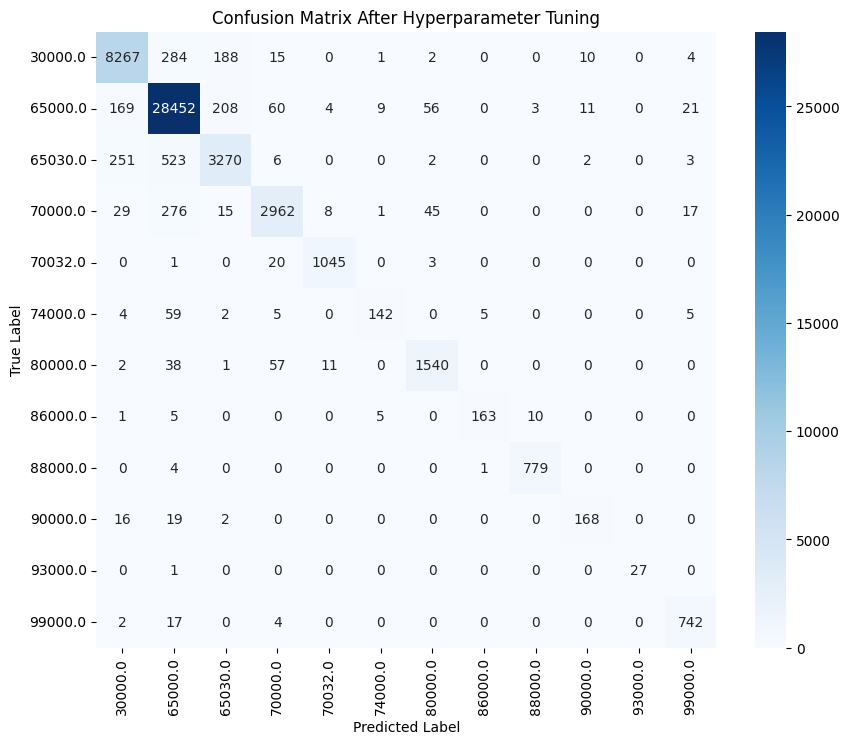


✅ Submission file saved as 'submission_xgb_tuned.csv'.


In [17]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train_data = pd.concat([pd.read_csv(os.path.join("Train dataset", file)) for file in os.listdir("Train dataset") if file.endswith('.csv')], ignore_index=True)
test_data = pd.read_csv("Test_dataset.csv")
labels_df = pd.read_csv("Labels_code.csv")
labels_df.columns = ["label_code", "label_name"]

# Hapus fitur dengan missing values lebih dari 80%
train_data.drop(columns=["DTS", "ROPA", "RMIC", "RXO"], inplace=True, errors='ignore')
test_data.drop(columns=["DTS", "ROPA", "RMIC", "RXO"], inplace=True, errors='ignore')

# Hapus kolom filename karena tidak berguna
train_data.drop(columns=["filename"], inplace=True, errors='ignore')
test_data.drop(columns=["filename"], inplace=True, errors='ignore')

# Konversi DTC ke numerik (jika ada nilai non-numerik, ubah ke NaN dulu)
train_data["DTC"] = pd.to_numeric(train_data["DTC"], errors='coerce')
test_data["DTC"] = pd.to_numeric(test_data["DTC"], errors='coerce')

# Hapus baris dengan target label NaN
train_data.dropna(subset=["Lithology_code"], inplace=True)

# Imputasi missing values pada fitur numerik dengan median
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("Lithology_code")  # Jangan imputasi target
train_data[numeric_cols] = train_data[numeric_cols].fillna(train_data[numeric_cols].median())
test_data[numeric_cols] = test_data[numeric_cols].fillna(test_data[numeric_cols].median())

# ✅ Feature Engineering (Tambah Fitur Baru)
train_data["RDEP_RSNA_ratio"] = train_data["RDEP"] / (train_data["RSHA"] + 1e-6)  # Hindari pembagian 0
test_data["RDEP_RSNA_ratio"] = test_data["RDEP"] / (test_data["RSHA"] + 1e-6)

train_data["SGR_GR_ratio"] = train_data["SGR"] / (train_data["GR"] + 1e-6)
test_data["SGR_GR_ratio"] = test_data["SGR"] / (test_data["GR"] + 1e-6)

train_data["GR_MA"] = train_data["GR"].rolling(window=5, min_periods=1).mean()
test_data["GR_MA"] = test_data["GR"].rolling(window=5, min_periods=1).mean()

train_data["Density_Porosity"] = train_data["RHOB"] * train_data["NPHI"]
test_data["Density_Porosity"] = test_data["RHOB"] * test_data["NPHI"]

# Encode target variable
label_encoder = LabelEncoder()
train_data["Lithology_code"] = label_encoder.fit_transform(train_data["Lithology_code"].astype(str))

# Standardize features
scaler = StandardScaler()
train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])
test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])

# Split training data
X_train, X_val, y_train, y_val = train_test_split(
    train_data[numeric_cols], train_data["Lithology_code"], test_size=0.2, stratify=train_data["Lithology_code"], random_state=42
)

# ✅ Hyperparameter Tuning dengan Optimasi RAM & CPU
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6],
    "learning_rate": [0.1, 0.2],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "gamma": [0, 0.1],
    "scale_pos_weight": [1, 5]
}

xgb = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), eval_metric='mlogloss', use_label_encoder=False)

# **Kurangi n_iter dan set n_jobs ke 1 atau 2 untuk mengurangi beban RAM**
grid_search = RandomizedSearchCV(xgb, param_grid, n_iter=10, scoring='f1_weighted', cv=2, verbose=1, n_jobs=2)
grid_search.fit(X_train, y_train)

# Gunakan parameter terbaik
best_params = grid_search.best_params_
print("\n✅ Best Hyperparameters:", best_params)

# Train XGBoost model dengan parameter terbaik
xgb_best = XGBClassifier(**best_params, objective='multi:softmax', num_class=len(label_encoder.classes_), eval_metric='mlogloss', use_label_encoder=False)
xgb_best.fit(X_train, y_train)

# Validate model
y_val_pred = xgb_best.predict(X_val)
f1_xgb = f1_score(y_val, y_val_pred, average='weighted')

# Menampilkan rincian F1 Score
class_report = classification_report(y_val, y_val_pred, target_names=label_encoder.classes_)
print("\n📊 Rincian F1 Score untuk Setiap Kelas:\n")
print(class_report)

# Confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix After Hyperparameter Tuning")
plt.show()

# Make predictions on test set
test_data["Lithology_code"] = xgb_best.predict(test_data[numeric_cols])

# Pastikan prediksi model dikembalikan ke kode lithology asli
test_data["Lithology_code"] = label_encoder.inverse_transform(test_data["Lithology_code"])

# **FIX: Konversi nilai ke float terlebih dahulu, lalu ke integer untuk mencegah ValueError**
test_data["Lithology_code"] = test_data["Lithology_code"].astype(float).astype(int)
labels_df["label_code"] = labels_df["label_code"].astype(int)

# Merge test_data dengan Labels_code.csv untuk mendapatkan label_name
test_data = test_data.merge(labels_df, left_on="Lithology_code", right_on="label_code", how="left")

# Hanya simpan kolom yang dibutuhkan untuk submission
submission = test_data[["uuid", "label_name"]]

# Simpan file submission
submission_file = "submission_xgb_tuned.csv"
submission.to_csv(submission_file, index=False)

print(f"\n✅ Submission file saved as '{submission_file}'.")

In [18]:
x = pd.read_csv ('submission_xgb_tuned.csv')
print(x['label_name'].value_counts())

label_name
Shale              72049
Limestone          21753
Sandstone          15394
Sandstone/Shale    10324
Coal                 660
Chalk                601
Anhydrite            419
Marl                 238
Halite               230
Dolomite              92
Basement              29
Tuff                   8
Name: count, dtype: int64



🔍 Evaluating Threshold = 0.5...


📌 Kolom yang tersedia setelah merge: Index(['uuid', 'file_name', 'BS', 'PEF', 'DCAL', 'ROP', 'SP', 'RMED', 'GR',
       'DTC', 'MUDWEIGHT', 'Y_LOC', 'DRHO', 'DEPTH_MD', 'RHOB', 'NPHI', 'SGR',
       'X_LOC', 'CALI', 'RSHA', 'Z_LOC', 'RDEP', 'DEPT', 'Lithology_code',
       'label_code_x', 'label_name_x', 'label_code_y', 'label_name_y',
       'label_code', 'label_name'],
      dtype='object')

🔎 Contoh hasil merge:
      uuid file_name        BS       PEF      DCAL       ROP        SP  \
0   14812  25_10-10 -0.185906 -0.260660 -0.017204  0.217583 -0.436442   
1   72908  25_10-10 -0.185906 -0.230383 -0.017219  0.292626 -0.436442   
2  103104  25_10-10 -0.185906 -0.157696 -0.017231  0.338140 -0.436442   
3   23480  25_10-10 -0.185906 -0.092710 -0.017390  0.430617 -0.436442   
4  104267  25_10-10 -0.185906 -0.047728 -0.017216  0.424378 -0.436442   

       RMED        GR       DTC  ...     Z_LOC      RDEP      DEPT  \
0 -0.063100 -0.326938  0.364154  ...

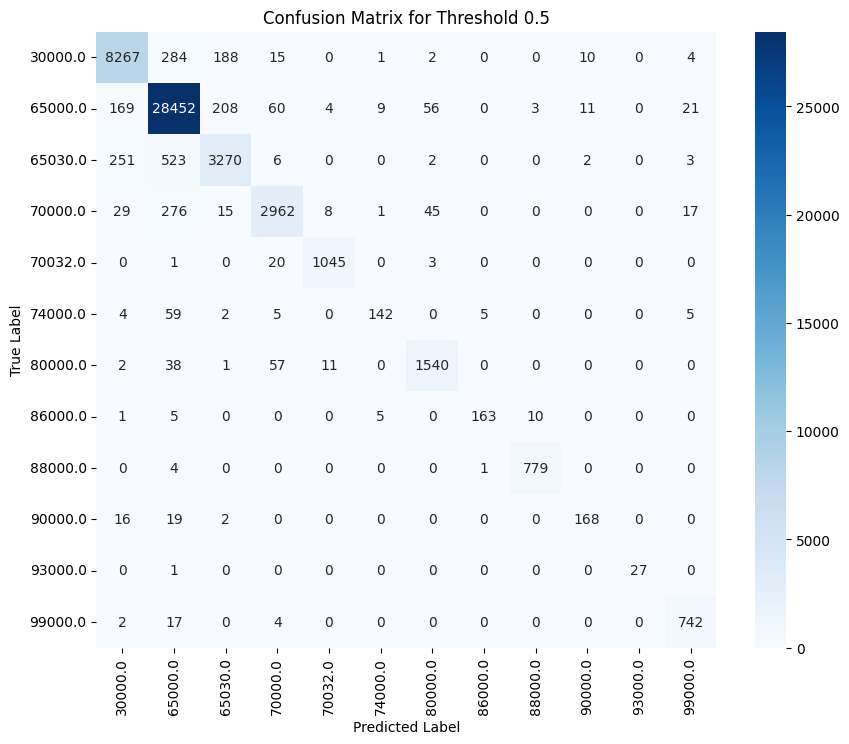


🔍 Evaluating Threshold = 0.6...


📌 Kolom yang tersedia setelah merge: Index(['uuid', 'file_name', 'BS', 'PEF', 'DCAL', 'ROP', 'SP', 'RMED', 'GR',
       'DTC', 'MUDWEIGHT', 'Y_LOC', 'DRHO', 'DEPTH_MD', 'RHOB', 'NPHI', 'SGR',
       'X_LOC', 'CALI', 'RSHA', 'Z_LOC', 'RDEP', 'DEPT', 'Lithology_code',
       'label_code_x', 'label_name_x', 'label_code_y', 'label_name_y',
       'label_code', 'label_name'],
      dtype='object')

🔎 Contoh hasil merge:
      uuid file_name        BS       PEF      DCAL       ROP        SP  \
0   14812  25_10-10 -0.185906 -0.260660 -0.017204  0.217583 -0.436442   
1   72908  25_10-10 -0.185906 -0.230383 -0.017219  0.292626 -0.436442   
2  103104  25_10-10 -0.185906 -0.157696 -0.017231  0.338140 -0.436442   
3   23480  25_10-10 -0.185906 -0.092710 -0.017390  0.430617 -0.436442   
4  104267  25_10-10 -0.185906 -0.047728 -0.017216  0.424378 -0.436442   

       RMED        GR       DTC  ...     Z_LOC      RDEP      DEPT  \
0 -0.063100 -0.326938  0.364154  ...

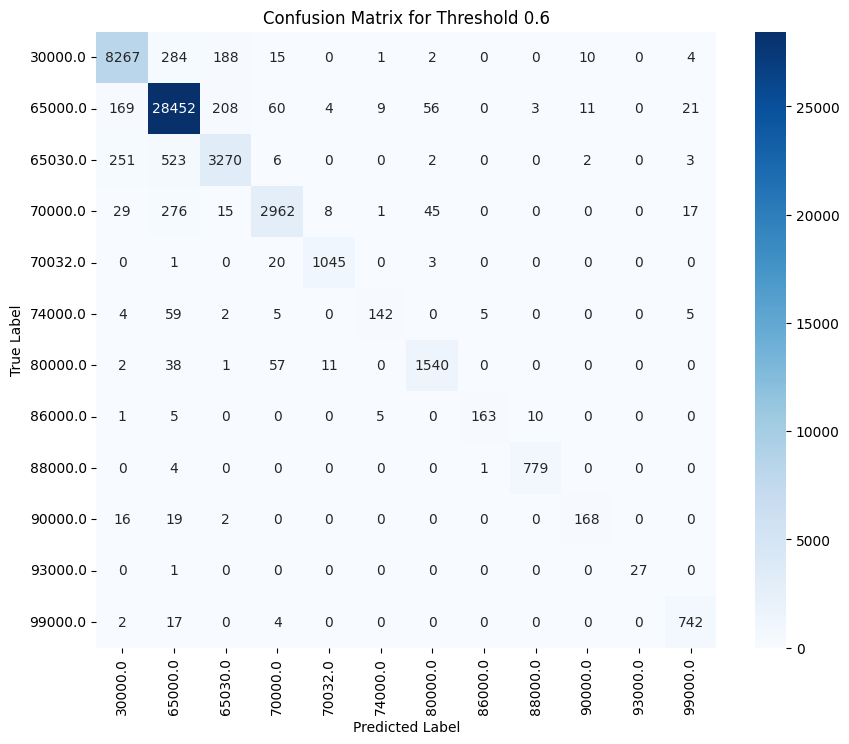


🔍 Evaluating Threshold = 0.7...


📌 Kolom yang tersedia setelah merge: Index(['uuid', 'file_name', 'BS', 'PEF', 'DCAL', 'ROP', 'SP', 'RMED', 'GR',
       'DTC', 'MUDWEIGHT', 'Y_LOC', 'DRHO', 'DEPTH_MD', 'RHOB', 'NPHI', 'SGR',
       'X_LOC', 'CALI', 'RSHA', 'Z_LOC', 'RDEP', 'DEPT', 'Lithology_code',
       'label_code_x', 'label_name_x', 'label_code_y', 'label_name_y',
       'label_code', 'label_name'],
      dtype='object')

🔎 Contoh hasil merge:
      uuid file_name        BS       PEF      DCAL       ROP        SP  \
0   14812  25_10-10 -0.185906 -0.260660 -0.017204  0.217583 -0.436442   
1   72908  25_10-10 -0.185906 -0.230383 -0.017219  0.292626 -0.436442   
2  103104  25_10-10 -0.185906 -0.157696 -0.017231  0.338140 -0.436442   
3   23480  25_10-10 -0.185906 -0.092710 -0.017390  0.430617 -0.436442   
4  104267  25_10-10 -0.185906 -0.047728 -0.017216  0.424378 -0.436442   

       RMED        GR       DTC  ...     Z_LOC      RDEP      DEPT  \
0 -0.063100 -0.326938  0.364154  ...

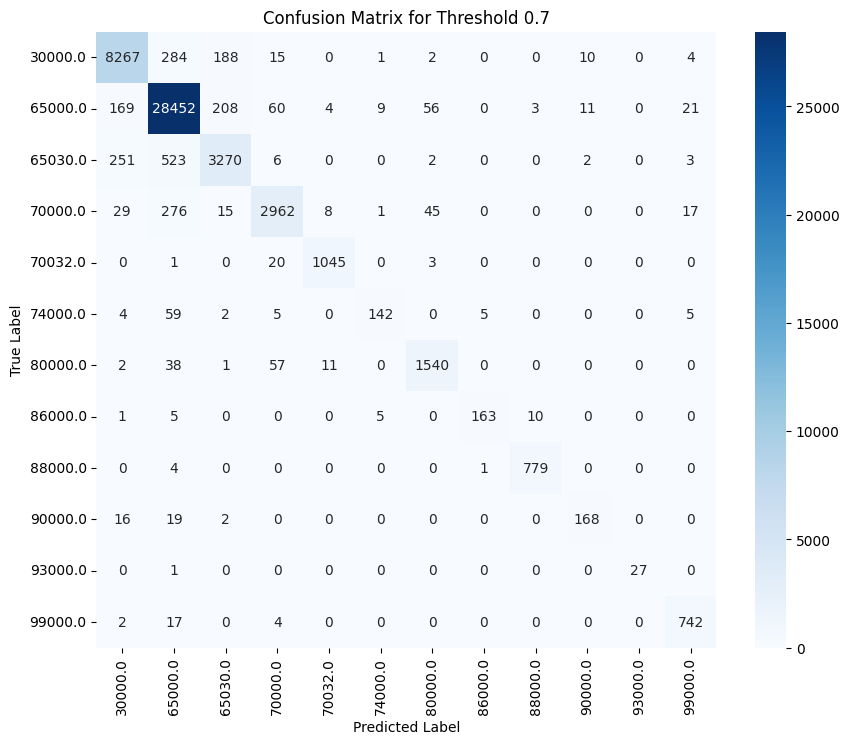


🔍 Evaluating Threshold = 0.8...


📌 Kolom yang tersedia setelah merge: Index(['uuid', 'file_name', 'BS', 'PEF', 'DCAL', 'ROP', 'SP', 'RMED', 'GR',
       'DTC', 'MUDWEIGHT', 'Y_LOC', 'DRHO', 'DEPTH_MD', 'RHOB', 'NPHI', 'SGR',
       'X_LOC', 'CALI', 'RSHA', 'Z_LOC', 'RDEP', 'DEPT', 'Lithology_code',
       'label_code_x', 'label_name_x', 'label_code_y', 'label_name_y',
       'label_code', 'label_name'],
      dtype='object')

🔎 Contoh hasil merge:
      uuid file_name        BS       PEF      DCAL       ROP        SP  \
0   14812  25_10-10 -0.185906 -0.260660 -0.017204  0.217583 -0.436442   
1   72908  25_10-10 -0.185906 -0.230383 -0.017219  0.292626 -0.436442   
2  103104  25_10-10 -0.185906 -0.157696 -0.017231  0.338140 -0.436442   
3   23480  25_10-10 -0.185906 -0.092710 -0.017390  0.430617 -0.436442   
4  104267  25_10-10 -0.185906 -0.047728 -0.017216  0.424378 -0.436442   

       RMED        GR       DTC  ...     Z_LOC      RDEP      DEPT  \
0 -0.063100 -0.326938  0.364154  ...

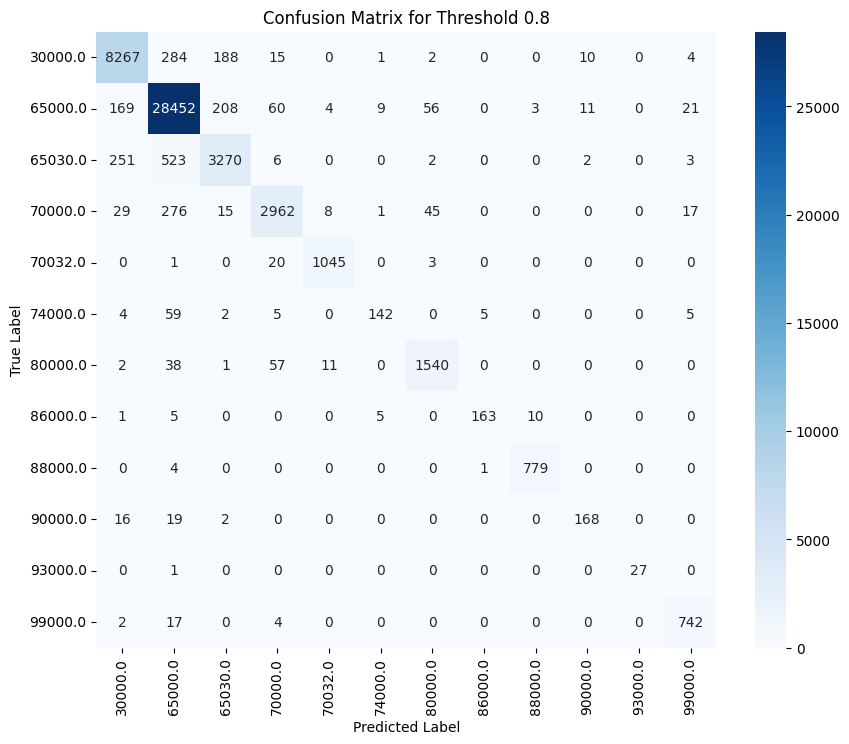


🚀 **Comparison of Thresholding Experiments:**
Threshold 0.5: F1 Score = 0.9489
Threshold 0.6: F1 Score = 0.9489
Threshold 0.7: F1 Score = 0.9489
Threshold 0.8: F1 Score = 0.9489

✅ All experiments completed!


In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Gunakan model yang sudah dilatih sebelumnya (xgb_best)
y_test_proba = xgb_best.predict_proba(test_data[numeric_cols])  # Probabilitas semua kelas

# **Eksperimen dengan Berbagai Threshold**
threshold_values = [0.5, 0.6, 0.7, 0.8]
results = {}

for threshold in threshold_values:
    print(f"\n🔍 Evaluating Threshold = {threshold}...\n")
    
    y_test_final = np.argmax(y_test_proba, axis=1)  # Default prediction
    for i in range(y_test_proba.shape[0]):
        if max(y_test_proba[i]) < threshold:
            y_test_final[i] = np.argmax(y_test_proba[i])  # Gunakan prediksi default
    
    # Pastikan prediksi model dikembalikan ke kode lithology asli
    test_data["Lithology_code"] = label_encoder.inverse_transform(y_test_final)
    
    # **FIX: Konversi tipe data agar cocok saat merge**
    test_data["Lithology_code"] = test_data["Lithology_code"].astype(float).astype(int)
    labels_df["label_code"] = labels_df["label_code"].astype(int)

    # **FIX: Hapus duplikasi kolom sebelum merge**
    test_data.drop(columns=["label_code", "label_name"], inplace=True, errors='ignore')

    # Merge test_data dengan Labels_code.csv untuk mendapatkan label_name
    test_data = test_data.merge(labels_df, left_on="Lithology_code", right_on="label_code", how="left", suffixes=("", "_duplicate"))

    # **Hapus kolom duplikat yang tidak dibutuhkan**
    test_data.drop(columns=["label_code_duplicate"], inplace=True, errors='ignore')

    # **Cek apakah merge berhasil**
    print("\n📌 Kolom yang tersedia setelah merge:", test_data.columns)
    print("\n🔎 Contoh hasil merge:\n", test_data.head())

    if "label_name" not in test_data.columns:
        raise KeyError("❌ Merge gagal: 'label_name' tidak ditemukan di test_data. Periksa tipe data!")

    # Hanya simpan kolom yang dibutuhkan untuk submission
    submission = test_data[["uuid", "label_name"]]

    # Simpan file submission
    submission_file = f"submission_xgb_threshold_{int(threshold*100)}.csv"
    submission.to_csv(submission_file, index=False)

    print(f"\n✅ Submission file saved as '{submission_file}'.\n")

    # **Evaluasi Performansi pada Validation Set**
    y_val_proba = xgb_best.predict_proba(X_val)
    y_val_final = np.argmax(y_val_proba, axis=1)
    for i in range(y_val_proba.shape[0]):
        if max(y_val_proba[i]) < threshold:
            y_val_final[i] = np.argmax(y_val_proba[i])

    f1 = f1_score(y_val, y_val_final, average='weighted')
    class_report = classification_report(y_val, y_val_final, target_names=label_encoder.classes_)

    print(f"📊 F1 Score for Threshold {threshold}: {f1:.4f}\n")
    print(class_report)

    # **Simpan hasil evaluasi**
    results[threshold] = f1

    # **Confusion Matrix**
    plt.figure(figsize=(10, 8))
    conf_matrix = confusion_matrix(y_val, y_val_final)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for Threshold {threshold}")
    plt.show()

# **Print hasil eksperimen thresholding**
print("\n🚀 **Comparison of Thresholding Experiments:**")
for t, f1 in results.items():
    print(f"Threshold {t}: F1 Score = {f1:.4f}")

print("\n✅ All experiments completed!")


In [28]:
x = pd.read_csv ('submission_xgb_threshold_50.csv ')
print(x['label_name'].value_counts())

label_name
Shale              72049
Limestone          21753
Sandstone          15394
Sandstone/Shale    10324
Coal                 660
Chalk                601
Anhydrite            419
Marl                 238
Halite               230
Dolomite              92
Basement              29
Tuff                   8
Name: count, dtype: int64


In [29]:
x = pd.read_csv ('submission_xgb_threshold_60.csv ')
print(x['label_name'].value_counts())

label_name
Shale              72049
Limestone          21753
Sandstone          15394
Sandstone/Shale    10324
Coal                 660
Chalk                601
Anhydrite            419
Marl                 238
Halite               230
Dolomite              92
Basement              29
Tuff                   8
Name: count, dtype: int64


📥 Loading datasets...
🛠️ Cleaning data...
✨ Adding new features...
🔄 Encoding target variable...
📏 Standardizing features...
✂️ Splitting data into train & validation sets...
🚀 Starting hyperparameter tuning & training...
Fitting 2 folds for each of 10 candidates, totalling 20 fits


c:\Users\yudha\OneDrive\Dokumen\MY JOURNEY\ML-SLB\SCALE-UP+ELIMINATION+ROUND+CASE+AND+PROBLEM\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Best Hyperparameters: {'subsample': 0.7, 'scale_pos_weight': 5, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}


c:\Users\yudha\OneDrive\Dokumen\MY JOURNEY\ML-SLB\SCALE-UP+ELIMINATION+ROUND+CASE+AND+PROBLEM\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 F1 Score: 0.9537397791293291

📊 Classification Report:
              precision    recall  f1-score   support

     30000.0       0.95      0.95      0.95      8771
     65000.0       0.96      0.98      0.97     28993
     65030.0       0.90      0.84      0.87      4057
     70000.0       0.95      0.89      0.92      3353
     70032.0       0.98      0.98      0.98      1069
     74000.0       0.89      0.65      0.75       222
     80000.0       0.94      0.94      0.94      1649
     86000.0       0.95      0.89      0.92       184
     88000.0       0.98      0.99      0.99       784
     90000.0       0.86      0.82      0.84       205
     93000.0       1.00      0.96      0.98        28
     99000.0       0.95      0.97      0.96       765

    accuracy                           0.95     50080
   macro avg       0.94      0.91      0.92     50080
weighted avg       0.95      0.95      0.95     50080



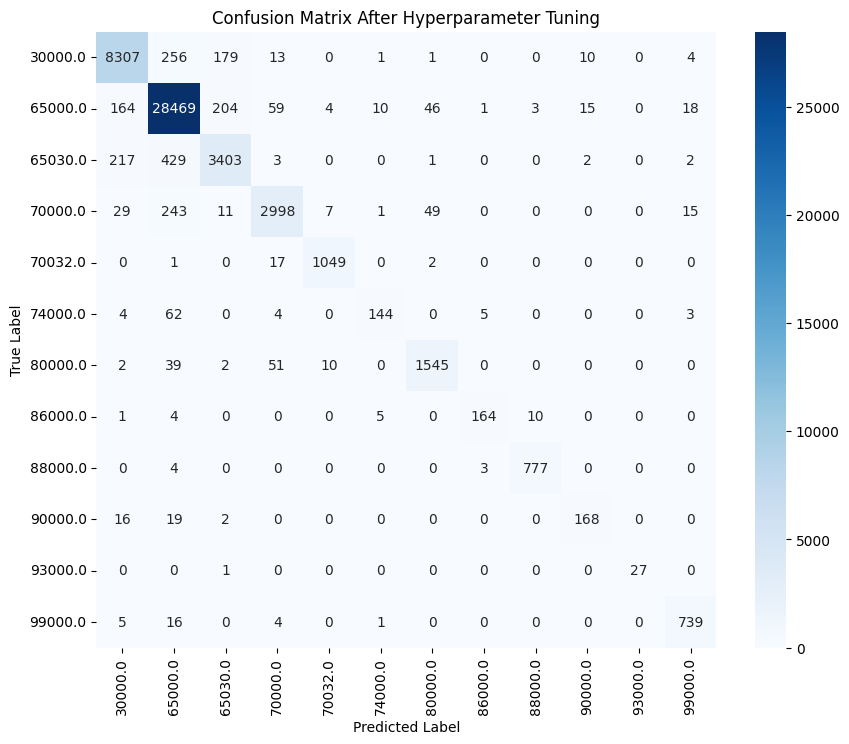

🔍 Predicting test data...
🔄 Merging with label codes...

✅ Submission file saved as 'submission_xgb_tuned_2.csv'.


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ **1. Load Dataset**
print("📥 Loading datasets...")
train_data = pd.concat([pd.read_csv(os.path.join("Train dataset", file)) for file in os.listdir("Train dataset") if file.endswith('.csv')], ignore_index=True)
test_data = pd.read_csv("Test_dataset.csv")
labels_df = pd.read_csv("Labels_code.csv")
labels_df.columns = ["label_code", "label_name"]

# ✅ **2. Data Cleaning & Handling Missing Values**
print("🛠️ Cleaning data...")
train_data.drop(columns=["DTS", "ROPA", "RMIC", "RXO"], inplace=True, errors='ignore')
test_data.drop(columns=["DTS", "ROPA", "RMIC", "RXO"], inplace=True, errors='ignore')

train_data.drop(columns=["filename"], inplace=True, errors='ignore')
test_data.drop(columns=["filename"], inplace=True, errors='ignore')

train_data["DTC"] = pd.to_numeric(train_data["DTC"], errors='coerce')
test_data["DTC"] = pd.to_numeric(test_data["DTC"], errors='coerce')

train_data.dropna(subset=["Lithology_code"], inplace=True)

numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("Lithology_code")  # Jangan imputasi target
train_data[numeric_cols] = train_data[numeric_cols].fillna(train_data[numeric_cols].median())
test_data[numeric_cols] = test_data[numeric_cols].fillna(test_data[numeric_cols].median())

# ✅ **3. Feature Engineering (Tambah Fitur Baru)**
print("✨ Adding new features...")
train_data["RDEP_RSNA_ratio"] = train_data["RDEP"] / (train_data["RSHA"] + 1e-6)  
test_data["RDEP_RSNA_ratio"] = test_data["RDEP"] / (test_data["RSHA"] + 1e-6)

train_data["SGR_GR_ratio"] = train_data["SGR"] / (train_data["GR"] + 1e-6)
test_data["SGR_GR_ratio"] = test_data["SGR"] / (test_data["GR"] + 1e-6)

train_data["GR_MA"] = train_data["GR"].rolling(window=5, min_periods=1).mean()
test_data["GR_MA"] = test_data["GR"].rolling(window=5, min_periods=1).mean()

train_data["Density_Porosity"] = train_data["RHOB"] * train_data["NPHI"]
test_data["Density_Porosity"] = test_data["RHOB"] * test_data["NPHI"]

train_data["Sonic_Density_Index"] = train_data["DTC"] / (train_data["RHOB"] + 1e-6)
test_data["Sonic_Density_Index"] = test_data["DTC"] / (test_data["RHOB"] + 1e-6)

# ✅ **4. Encode Target Variable**
print("🔄 Encoding target variable...")
label_encoder = LabelEncoder()
train_data["Lithology_code"] = label_encoder.fit_transform(train_data["Lithology_code"].astype(str))

# ✅ **5. Standardize Features**
print("📏 Standardizing features...")
scaler = StandardScaler()
train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])
test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])

# ✅ **6. Split Training & Validation Set**
print("✂️ Splitting data into train & validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    train_data[numeric_cols], train_data["Lithology_code"], test_size=0.2, stratify=train_data["Lithology_code"], random_state=42
)

# ✅ **7. Hyperparameter Tuning & Model Training**
print("🚀 Starting hyperparameter tuning & training...")
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6],
    "learning_rate": [0.1, 0.2],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "gamma": [0, 0.1],
    "scale_pos_weight": [1, 5]
}

xgb = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), eval_metric='mlogloss', use_label_encoder=False)

grid_search = RandomizedSearchCV(xgb, param_grid, n_iter=10, scoring='f1_weighted', cv=2, verbose=1, n_jobs=2)
grid_search.fit(X_train, y_train)

# ✅ **8. Train Model dengan Hyperparameter Terbaik**
best_params = grid_search.best_params_
print("\n✅ Best Hyperparameters:", best_params)

xgb_best = XGBClassifier(**best_params, objective='multi:softmax', num_class=len(label_encoder.classes_), eval_metric='mlogloss', use_label_encoder=False)
xgb_best.fit(X_train, y_train)

# ✅ **9. Evaluasi Model**
y_val_pred = xgb_best.predict(X_val)
f1_xgb = f1_score(y_val, y_val_pred, average='weighted')
print("\n📊 F1 Score:", f1_xgb)

print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix After Hyperparameter Tuning")
plt.show()

# ✅ **10. Prediction on Test Data**
print("🔍 Predicting test data...")
test_data["Lithology_code"] = xgb_best.predict(test_data[numeric_cols])

test_data["Lithology_code"] = label_encoder.inverse_transform(test_data["Lithology_code"])

# ✅ **11. Merge dengan Labels_code.csv**
print("🔄 Merging with label codes...")
test_data["Lithology_code"] = test_data["Lithology_code"].astype(float).astype(int)
labels_df["label_code"] = labels_df["label_code"].astype(int)
test_data = test_data.merge(labels_df, left_on="Lithology_code", right_on="label_code", how="left")

# ✅ **12. Save Submission**
submission = test_data[["uuid", "label_name"]]
submission_file = "submission_xgb_tuned_2.csv"
submission.to_csv(submission_file, index=False)

print(f"\n✅ Submission file saved as '{submission_file}'.")

In [37]:
x = pd.read_csv ('submission_xgb_tuned_2.csv')
print(x['label_name'].value_counts())

label_name
Shale              68782
Sandstone          19665
Limestone          16494
Sandstone/Shale    12300
Marl                1523
Chalk               1291
Anhydrite            604
Coal                 542
Halite               495
Tuff                  46
Basement              29
Dolomite              26
Name: count, dtype: int64
